In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

df = spark.read.json("harvester/ct/bigharvey-CT*-202306*.jsonl.gz")

In [2]:
df.printSchema()

root
 |-- crawler: string (nullable = true)
 |-- debug_steps: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- identifier: string (nullable = true)
 |-- jobposting: string (nullable = true)
 |-- scraped_at: string (nullable = true)
 |-- search_engine_type: string (nullable = true)
 |-- url: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- version: string (nullable = true)



In [3]:
df.count()

2794478

In [4]:
spark.sparkContext.defaultParallelism, df.rdd.getNumPartitions()

(4, 16)

In [5]:
spark.conf.get("spark.sql.adaptive.enabled")

'true'

In [6]:
#import json
#s = json.loads((df.select("jobposting").where("version = '0.0.9'").limit(1).first()['jobposting']))
jsonobj = spark.read.json("jobposting_sample.json", multiLine=True)
schema = jsonobj.schema
schema

StructType([StructField('@context', StringType(), True), StructField('@type', StringType(), True), StructField('baseSalary', StructType([StructField('@context', StringType(), True), StructField('@type', StringType(), True), StructField('currency', StringType(), True), StructField('value', StructType([StructField('@context', StringType(), True), StructField('@type', StringType(), True), StructField('unitText', StringType(), True), StructField('value', StringType(), True)]), True)]), True), StructField('datePosted', StringType(), True), StructField('description', StringType(), True), StructField('directApply', BooleanType(), True), StructField('employmentType', StringType(), True), StructField('hiringOrganization', StructType([StructField('@context', StringType(), True), StructField('@type', StringType(), True), StructField('logo', StringType(), True), StructField('name', StringType(), True)]), True), StructField('identifier', StructType([StructField('@context', StringType(), True), Stru

In [7]:
df.where("version = '0.0.7'").withColumn("jp", F.from_json(F.col("jobposting"), schema)).printSchema()

root
 |-- crawler: string (nullable = true)
 |-- debug_steps: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- identifier: string (nullable = true)
 |-- jobposting: string (nullable = true)
 |-- scraped_at: string (nullable = true)
 |-- search_engine_type: string (nullable = true)
 |-- url: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- version: string (nullable = true)
 |-- jp: struct (nullable = true)
 |    |-- @context: string (nullable = true)
 |    |-- @type: string (nullable = true)
 |    |-- baseSalary: struct (nullable = true)
 |    |    |-- @context: string (nullable = true)
 |    |    |-- @type: string (nullable = true)
 |    |    |-- currency: string (nullable = true)
 |    |    |-- value: struct (nullable = true)
 |    |    |    |-- @context: string (nullable = true)
 |    |    |    |-- @type: string (nullable = true)
 |    |    |    |-- unitText: string (nullable = true)
 |    |    |    |-- value: string (nullable = true)
 |  

In [8]:
df.where("version = '0.0.9'").withColumn("jp", F.from_json(F.col("jobposting"), schema)).select("jp.url").count()

1138061

In [9]:
df.where("version = '0.0.9'").withColumn("jp", F.from_json(F.col("jobposting"), schema)).select("jp.url").distinct().count()

159767

In [10]:
df.where("version = '0.0.9'").withColumn("jp", F.from_json(F.col("jobposting"), schema)).select("uuid").distinct().count()

1138061

## Stats

In [11]:
stats_df = spark.read.json("harvester/ct/*stats.json")
stats_df.printSchema()

root
 |-- downloader/request_bytes: long (nullable = true)
 |-- downloader/request_count: long (nullable = true)
 |-- downloader/request_method_count/GET: long (nullable = true)
 |-- downloader/response_bytes: long (nullable = true)
 |-- downloader/response_count: long (nullable = true)
 |-- downloader/response_status_count/200: long (nullable = true)
 |-- downloader/response_status_count/301: long (nullable = true)
 |-- downloader/response_status_count/403: long (nullable = true)
 |-- downloader/response_status_count/404: long (nullable = true)
 |-- downloader/response_status_count/500: long (nullable = true)
 |-- downloader/response_status_count/504: long (nullable = true)
 |-- dupefilter/filtered: long (nullable = true)
 |-- elapsed_time_seconds: double (nullable = true)
 |-- feedexport/success_count/FileFeedStorage: long (nullable = true)
 |-- finish_reason: string (nullable = true)
 |-- finish_time: string (nullable = true)
 |-- httpcompression/response_bytes: long (nullable = tru

<Axes: xlabel='start_time'>

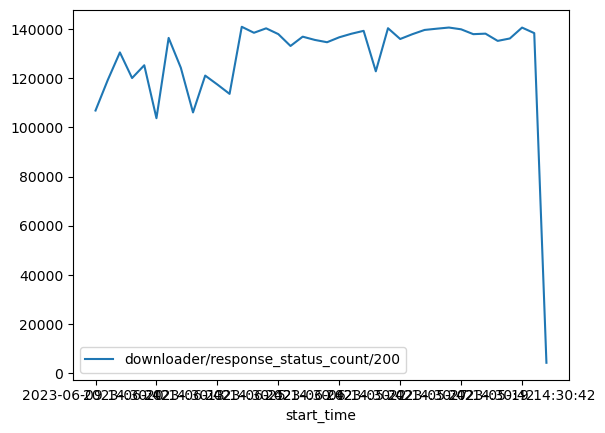

In [12]:
stats_df.toPandas().plot("start_time", "downloader/response_status_count/200")

In [13]:
df.rdd.mapPartitionsWithIndex(lambda x, it: [(x, sum(1 for _ in it))]).collect()

[(0, 122970),
 (1, 122478),
 (2, 120862),
 (3, 120437),
 (4, 129957),
 (5, 118909),
 (6, 128583),
 (7, 244859),
 (8, 240933),
 (9, 254845),
 (10, 236223),
 (11, 220916),
 (12, 225828),
 (13, 217066),
 (14, 199775),
 (15, 89837)]